In [ ]:
import math
import time
import random
from dataclasses import dataclass
from pathlib import Path
import torchaudio.functional as F
from typing import List, Dict, Tuple
import sys
import soundfile as sf
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    get_linear_schedule_with_warmup,
)
from peft import LoraConfig, get_peft_model

In [ ]:
def load_audio(filepath, target_sr=16000):
    waveform_np, sr = sf.read(filepath, dtype="float32")  
    waveform = torch.from_numpy(waveform_np)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)  
    elif waveform.ndim == 2:
        waveform = waveform.transpose(0, 1)

    # Resample if needed
    if sr != target_sr:
        waveform = F.resample(waveform, sr, target_sr)
        sr = target_sr

    return waveform, sr

In [ ]:
try:
    import editdistance  
except ImportError:
    editdistance = None


def _levenshtein(seq_a, seq_b):
    dp = list(range(len(seq_b) + 1))
    for i, ca in enumerate(seq_a, 1):
        prev = dp[0]
        dp[0] = i
        for j, cb in enumerate(seq_b, 1):
            cur = dp[j]
            dp[j] = min(
                dp[j] + 1,          
                dp[j - 1] + 1,      
                prev + (ca != cb),  
            )
            prev = cur
    return dp[-1]


def _edit_distance(a, b):
    if editdistance is not None:
        return editdistance.eval(a, b)
    return _levenshtein(a, b)


def compute_cer(reference, hypothesis):
    if isinstance(reference, list):
        if not isinstance(hypothesis, list) or len(reference) != len(hypothesis):
            raise ValueError('reference and hypothesis must be lists of the same length')
        if len(reference) == 0:
            return 0.0
        return float(np.mean([compute_cer(r, h) for r, h in zip(reference, hypothesis)]))
    if len(reference) == 0:
        return 0.0 if len(hypothesis) == 0 else 1.0
    distance = _edit_distance(reference, hypothesis)
    return distance / len(reference)


def compute_wer(reference, hypothesis):
    if isinstance(reference, list):
        if not isinstance(hypothesis, list) or len(reference) != len(hypothesis):
            raise ValueError('reference and hypothesis must be lists of the same length')
        if len(reference) == 0:
            return 0.0
        return float(np.mean([compute_wer(r, h) for r, h in zip(reference, hypothesis)]))
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    if len(ref_words) == 0:
        return 0.0 if len(hyp_words) == 0 else 1.0
    distance = _edit_distance(ref_words, hyp_words)
    return distance / len(ref_words)




def evaluate_loss(model, dloader: DataLoader, device: str) -> float:
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for batch in tqdm(dloader, desc="Eval loss", leave=False):
            input_features = batch['input_features'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            loss = model(input_features=input_features, attention_mask=attention_mask, labels=labels).loss
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)


def run_eval(model, processor: WhisperProcessor, dloader: DataLoader, split_name: str, device: str):
    model.eval()
    refs, hyps = [], []
    with torch.no_grad():
        for batch in tqdm(dloader, desc=f"Eval {split_name}", leave=False):
            input_features = batch['input_features'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            generated_ids = model.generate(
                input_features=input_features,
                attention_mask=attention_mask,
                language="id",
                task="transcribe",
            )
            transcripts = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            label_ids = labels.clone()
            label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
            ref_texts = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
            refs.extend(ref_texts)
            hyps.extend(transcripts)
    wer = compute_wer(refs, hyps)
    cer = compute_cer(refs, hyps)
    avg_score = 0.5 * (wer + cer)
    print(f"{split_name} WER: {wer:.4f} | CER: {cer:.4f} | Avg: {avg_score:.4f}")
    return wer, cer, avg_score

class WhisperAudioDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = load_audio(row['AudioPath'], target_sr=16000)
        waveform = waveform.mean(0)
        return {
            'audio': waveform,
            'sampling_rate': sr,
            'text': row['Transcript'],
            'sentence_id': row['SentenceID'],
        }


def make_collate_fn(processor: WhisperProcessor):
    max_length = processor.feature_extractor.n_samples
    def collate(batch: List[Dict]):
        audios = [b['audio'].squeeze().cpu().numpy() for b in batch]
        texts = [b['text'] for b in batch]
        inputs = processor(
            audios,
            sampling_rate=16000,
            return_tensors='pt',
            padding='max_length',
            max_length=max_length,
            truncation=True,
            return_attention_mask=True,
        )
        labels = processor.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
        )
        labels['input_ids'][labels['input_ids'] == processor.tokenizer.pad_token_id] = -100
        return {
            'input_features': inputs.input_features,
            'attention_mask': inputs.attention_mask,
            'labels': labels['input_ids'],
        }
    return collate


def load_splits(csv_path: str = '../sorted_data.csv') -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(csv_path)
    if 'Split' not in df.columns:
        raise ValueError("sorted_data.csv missing 'Split' column. Re-run data_sorting.py to add Split labels.")
    train_df = df[df['Split'] == 'train'].copy()
    val_df = df[df['Split'] == 'val'].copy()
    test_df = df[df['Split'] == 'test'].copy()
    return train_df, val_df, test_df

def count_trainable_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable/1e6:.2f}M / {total/1e6:.2f}M total")
    return trainable, total



In [4]:

@dataclass
class TrainConfig:
    model_name: str = "openai/whisper-medium"  
    batch_size: int = 4
    num_epochs: int = 10
    lr: float = 1e-5
    seed: int = 42
    patience: int = 5
    use_lora: bool = True
    lora_r: int = 32
    lora_alpha: int = 64
    lora_dropout: float = 0.05
    lora_target_modules: list = None
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def train_and_eval(config: TrainConfig):
    set_seed(config.seed)
    start_time = time.time()
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

    train_df, val_df, test_df = load_splits()
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
    print(f"Using device: {config.device} ({device_name})")

    processor = WhisperProcessor.from_pretrained(config.model_name)
    model = WhisperForConditionalGeneration.from_pretrained(config.model_name)
    model.generation_config.language = "id"

    if config.use_lora:
        lora_cfg = LoraConfig(
            r=config.lora_r,
            lora_alpha=config.lora_alpha,
            lora_dropout=config.lora_dropout,
            target_modules=["q_proj", "v_proj"],
            bias="none",
        )
        model = get_peft_model(model, lora_cfg)
        model.print_trainable_parameters()
    trainable_params, total_params = count_trainable_params(model)
    model.to(config.device)

    train_ds = WhisperAudioDataset(train_df)
    val_ds = WhisperAudioDataset(val_df)
    test_ds = WhisperAudioDataset(test_df)

    collate_fn = make_collate_fn(processor)
    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps,
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(config.num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs}", leave=False)
        for step, batch in enumerate(pbar, 1):
            optimizer.zero_grad()
            input_features = batch['input_features'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            labels = batch['labels'].to(config.device)
            loss = model(input_features=input_features, attention_mask=attention_mask, labels=labels).loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            if step % 10 == 0 or step == 1:
                pbar.set_postfix(loss=running_loss / step)
        avg_loss = running_loss / max(1, len(train_loader))
        train_losses.append(avg_loss)
        val_loss = evaluate_loss(model, val_loader, config.device)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{config.num_epochs} | Train loss: {avg_loss:.4f} | Val loss: {val_loss:.4f}")

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= config.patience:
                print(f"Early stopping at epoch {epoch+1} (no val improvement for {config.patience} epochs). Best val loss {best_val_loss:.4f} at epoch {best_epoch}.")
                break

    elapsed = time.time() - start_time
    print(f"Total train+eval time: {elapsed/60:.2f} min ({elapsed:.1f} s) on {device_name}")
    print(f"Best val loss: {best_val_loss:.4f} at epoch {best_epoch}")

    metrics = []
    for epoch_idx, (tr_loss, vl_loss) in enumerate(zip(train_losses, val_losses), start=1):
        metrics.append({
            'epoch': epoch_idx,
            'train_loss': tr_loss,
            'val_loss': vl_loss,
            'model': config.model_name,
            'batch_size': config.batch_size,
            'lr': config.lr,
            'num_epochs': config.num_epochs,
            'seed': config.seed,
            'patience': config.patience,
            'device': device_name,
            'use_lora': config.use_lora,
            'lora_r': config.lora_r,
            'lora_alpha': config.lora_alpha,
            'lora_dropout': config.lora_dropout,
            'trainable_params': trainable_params,
            'total_params': total_params,
        })
    csv_name = f"metrics_{config.model_name.replace('/', '-')}"         f"_bs{config.batch_size}_lr{config.lr}_ep{config.num_epochs}_pat{config.patience}_lora{int(config.use_lora)}_seed{config.seed}.csv"
    pd.DataFrame(metrics).to_csv(csv_name, index=False)
    print(f"Saved per-epoch metrics to {csv_name}")

    return train_losses, val_losses, processor, model, (train_loader, val_loader, test_loader), device_name


In [5]:
cfg = TrainConfig()
train_losses, val_losses, processor, model, (train_loader, val_loader, test_loader), device_name = train_and_eval(cfg)

Train: 1470 | Val: 210 | Test: 410
Using device: cuda (NVIDIA GeForce RTX 5090)
trainable params: 9,437,184 || all params: 773,295,104 || trainable%: 1.2204
Trainable params: 9.44M / 773.30M total


Epoch 1/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/10 | Train loss: 5.3110 | Val loss: 3.6589


Epoch 2/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/10 | Train loss: 3.0115 | Val loss: 2.6971


Epoch 3/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/10 | Train loss: 2.3855 | Val loss: 2.2092


Epoch 4/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/10 | Train loss: 1.7497 | Val loss: 1.2474


Epoch 5/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/10 | Train loss: 0.7397 | Val loss: 0.8125


Epoch 6/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/10 | Train loss: 0.6441 | Val loss: 0.7717


Epoch 7/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/10 | Train loss: 0.5974 | Val loss: 0.7468


Epoch 8/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/10 | Train loss: 0.5660 | Val loss: 0.7309


Epoch 9/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/10 | Train loss: 0.5482 | Val loss: 0.7215


Epoch 10/10:   0%|          | 0/368 [00:00<?, ?it/s]

Eval loss:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/10 | Train loss: 0.5379 | Val loss: 0.7182
Total train+eval time: 38.15 min (2288.7 s) on NVIDIA GeForce RTX 5090
Best val loss: 0.7182 at epoch 10
Saved per-epoch metrics to metrics_openai-whisper-medium_bs4_lr1e-05_ep10_pat5_lora1_seed42.csv


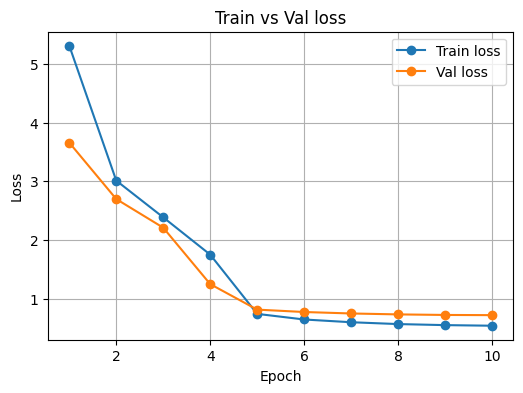

In [6]:
if not train_losses:
    print("No losses to plot. Re-run training; check for errors above.")
else:
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train loss", marker="o")
    plt.plot(epochs, val_losses, label="Val loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
# Final test evaluation (run after training)
test_wer, test_cer, test_avg = run_eval(model, processor, test_loader, "Test", cfg.device)
print(f"Test WER: {test_wer:.4f} | CER: {test_cer:.4f} | Avg: {test_avg:.4f}")


Eval Test:   0%|          | 0/103 [00:00<?, ?it/s]

Test WER: 0.6821 | CER: 0.2061 | Avg: 0.4441
Test WER: 0.6821 | CER: 0.2061 | Avg: 0.4441


In [8]:

# Inference on a random test audio
from IPython.display import Audio, display

# Reload test split
_, _, test_df = load_splits()

# Pick a random example
sample = test_df.sample(n=1, random_state=random.randint(0, 10_000)).iloc[0]

audio_path = Path(sample['AudioPath'])
waveform, sr = load_audio(audio_path, target_sr=16000)
waveform = waveform.mean(0)  # ensure mono

# Reuse trained objects if they exist; otherwise load fresh
if 'processor' not in globals():
    processor = WhisperProcessor.from_pretrained(cfg.model_name)
if 'model' not in globals():
    model = WhisperForConditionalGeneration.from_pretrained(cfg.model_name)
model.generation_config.language = "id"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None
model.to(cfg.device)
model.eval()

inputs = processor(
    waveform.cpu().numpy(),
    sampling_rate=sr,
    return_tensors='pt',
    padding='max_length',
    max_length=processor.feature_extractor.n_samples,
    truncation=True,
    return_attention_mask=True,
)
input_features = inputs.input_features.to(cfg.device)
attention_mask = inputs.attention_mask.to(cfg.device)

with torch.no_grad():
    generated_ids = model.generate(
        input_features=input_features,
        attention_mask=attention_mask,
        language="id",
        task="transcribe",
    )
    pred_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

display(Audio(str(audio_path), rate=sr))
print(f"Audio file: {audio_path}")
print(f"Reference: {sample['Transcript']}")
print(f"Prediction: {pred_text}")


Audio file: audio_input/audio_input/speaker09_m_nn_utt14.wav
Reference: kula badhe dhahar sekul pecel setunggal
Prediction:  Kula badi dhahar sekul pecel setunggal.
